# Pulse wave simulation tutorial

The goal of this tutorial is to calibrate a 1D pulse wave model of a bifurcation using pressure data at one of the outlets. <br>We will use the Bayesian optimization pipeline that we just demonstrated in the previous tutorial, but now we will use a more complex 1D model instead of a dummy 0D model.

This model has multiple parameters (length, radius, wall thickness, Young's modulus) for each vessel.<br> To make the problem tractable, we will only calibrate the Young's moduli of the two daughter vessels (E_1 and E_2) and assume that all other parameters are known. <br> We will also assume that we have pressure data at one of the outlets (P_out) and that the flow rate at the inlet (Q_in) is known. <br> The goal is to find the values of E_1 and E_2 that best match the observed pressure data at the outlet. The problem setup is illustrated below:

```

                        /
                       /
Q_in (known)          /  E_1: Young's modulus of daughter vessel 1 (parameter to be calibrated)
____________________ /
                     \
                      \  E_2: Young's modulus of daughter vessel 2 (parameter to be calibrated)
                       \
                        \  P_out: pressure at outlet 2 (data given at this location)
```

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# ==========================================
# Physical Constants (SI Units)
# ==========================================
rho = 1060.0        # kg/m^3
mu = 0.004          # Pa.s

# ==========================================
# 1D Distributed Model Class
# DISCLAIMER: this model was generated by an LLM and may contain errors. 
# It is intended for educational purposes and should be used with caution.
# ==========================================

class Vessel1D:
    def __init__(self, name, length, radius, thickness, E, nx):
        self.name = name
        self.L = length
        self.R0 = radius
        self.h = thickness
        self.E = E
        self.nx = nx
        self.dx = length / (nx - 1)
        
        # Grid
        self.x = np.linspace(0, length, nx)
        
        # Initial Conditions
        self.A0 = np.pi * self.R0**2
        self.A = np.ones(nx) * self.A0
        self.Q = np.zeros(nx)
        
        # Material Stiffness Parameter beta
        # P = beta * (sqrt(A) - sqrt(A0))
        self.beta = (np.sqrt(np.pi) * self.h * self.E) / (self.A0)
        
        # Friction parameter K_r (Poiseuille profile assumption)
        self.Kr = 8 * np.pi * mu / rho

    def get_P(self, A):
        return self.beta * (np.sqrt(A) - np.sqrt(self.A0))
    
    def get_c(self, A):
        # Wave speed c = sqrt(A/rho * dP/dA) = sqrt(beta/(2*rho) * A^0.5)
        return np.sqrt(self.beta / (2 * rho)) * (A**0.25)

    def step_maccormack(self, dt):
        # Explicit MacCormack scheme for interior nodes
        A = self.A
        Q = self.Q
        nx = self.nx
        
        # Predictor (Forward spatial difference)
        A_p = A.copy()
        Q_p = Q.copy()
        
        for i in range(0, nx-1):
            dA_dt = -(Q[i+1] - Q[i]) / self.dx
            
            # Non-conservative source term formulation
            term1 = (Q[i+1]**2/A[i+1] - Q[i]**2/A[i]) / self.dx
            P_curr = self.get_P(A[i])
            P_next = self.get_P(A[i+1])
            term2 = (A[i]/rho) * (P_next - P_curr) / self.dx
            friction = self.Kr * Q[i] / A[i]
            
            dQ_dt = -term1 - term2 - friction
            
            A_p[i] = A[i] + dt * dA_dt
            Q_p[i] = Q[i] + dt * dQ_dt
            
        # Extrapolate predictor at boundary for Corrector
        A_p[-1] = A_p[-2]
        Q_p[-1] = Q_p[-2]
            
        # Corrector (Backward spatial difference)
        A_new = A.copy()
        Q_new = Q.copy()
        
        for i in range(1, nx):
            dA_dt = -(Q_p[i] - Q_p[i-1]) / self.dx
            
            term1 = (Q_p[i]**2/A_p[i] - Q_p[i-1]**2/A_p[i-1]) / self.dx
            P_curr = self.get_P(A_p[i])
            P_prev = self.get_P(A_p[i-1])
            term2 = (A_p[i]/rho) * (P_curr - P_prev) / self.dx
            
            friction = self.Kr * Q_p[i] / A_p[i]
            
            dQ_dt = -term1 - term2 - friction
            
            A_new[i] = 0.5 * (A[i] + A_p[i] + dt * dA_dt)
            Q_new[i] = 0.5 * (Q[i] + Q_p[i] + dt * dQ_dt)

        self.A = A_new
        self.Q = Q_new
        return

# ==========================================
# 1D Boundary & Coupling Functions
# ==========================================
def solve_bifurcation(parent, d1, d2):
    # Indices: Parent End (-1), D1 Start (0), D2 Start (0)
    
    # Get current state for initial guess
    Ap_old, Qp_old = parent.A[-1], parent.Q[-1]
    Ad1_old, Qd1_old = d1.A[0], d1.Q[0]
    Ad2_old, Qd2_old = d2.A[0], d2.Q[0]
    
    # Characteristic Variables (Method of Characteristics)
    # Forward char from Parent (-2 -> -1)
    up = parent.Q[-2] / parent.A[-2]
    cp = parent.get_c(parent.A[-2])
    W_f_p = up + 4*cp
    
    # Backward char from D1 (1 -> 0)
    ud1 = d1.Q[1] / d1.A[1]
    cd1 = d1.get_c(d1.A[1])
    W_b_d1 = ud1 - 4*cd1
    
    # Backward char from D2 (1 -> 0)
    ud2 = d2.Q[1] / d2.A[1]
    cd2 = d2.get_c(d2.A[1])
    W_b_d2 = ud2 - 4*cd2
    
    # Solve system for boundary values: Ap, Qp, Ad1, Qd1, Ad2, Qd2
    def equations(vars):
        Ap, Qp, Ad1, Qd1, Ad2, Qd2 = vars
        
        # Velocities and Wave speeds at boundary
        up_new = Qp / Ap
        cp_new = parent.get_c(Ap)
        
        ud1_new = Qd1 / Ad1
        cd1_new = d1.get_c(Ad1)
        
        ud2_new = Qd2 / Ad2
        cd2_new = d2.get_c(Ad2)
        
        # Residuals
        res = np.zeros(6)
        
        # 1. Characteristic Equations
        res[0] = (up_new + 4*cp_new) - W_f_p
        res[1] = (ud1_new - 4*cd1_new) - W_b_d1
        res[2] = (ud2_new - 4*cd2_new) - W_b_d2
        
        # 4. Mass Continuity
        res[3] = Qp - (Qd1 + Qd2)
        
        # 5. Pressure Continuity (Parent = D1)
        Pp = parent.get_P(Ap)
        Pd1 = d1.get_P(Ad1)
        res[4] = Pp - Pd1
        
        # 6. Pressure Continuity (Parent = D2)
        Pd2 = d2.get_P(Ad2)
        res[5] = Pp - Pd2
        
        return res
    
    guess = [Ap_old, Qp_old, Ad1_old, Qd1_old, Ad2_old, Qd2_old]
    sol = fsolve(equations, guess)
    
    # Update Boundaries
    parent.A[-1], parent.Q[-1] = sol[0], sol[1]
    d1.A[0], d1.Q[0] = sol[2], sol[3]
    d2.A[0], d2.Q[0] = sol[4], sol[5]
    return

def apply_inlet_bc(vessel, t):
    # Sinusoidal input pulse
    period = 0.8
    if (t % period) < 0.3:
        Q_in = 1e-5 * np.sin(np.pi * (t % period) / 0.3)
    else:
        Q_in = 0.0
        
    # Solve for A_in using Backward Characteristic from interior
    u_int = vessel.Q[1] / vessel.A[1]
    c_int = vessel.get_c(vessel.A[1])
    W_b = u_int - 4*c_int
    
    # u_in - 4c_in = W_b  => Q_in/A_in - 4*c(A_in) = W_b
    def func(A):
        return (Q_in/A) - 4*vessel.get_c(A) - W_b
    
    A_in = fsolve(func, vessel.A[0])[0]
    
    vessel.Q[0] = Q_in
    vessel.A[0] = A_in
    return Q_in

def apply_outlet_bc(vessel):
    # Resistive/Absorbing Boundary Condition: P = Z0 * Q
    # Solved via Forward Characteristic from interior (-2 -> -1)
    
    # 1. Characteristic Variable coming from inside
    u_int = vessel.Q[-2] / vessel.A[-2]
    c_int = vessel.get_c(vessel.A[-2])
    W_f = u_int + 4*c_int
    
    # 2. Resistance (Characteristic Impedance of the vessel at rest)
    # Z0 = rho * c0 / A0
    c0 = np.sqrt(vessel.beta / (2 * rho)) * (vessel.A0**0.25)
    R_out = rho * c0 / vessel.A0
    
    # 3. Solve for Boundary Area A_out
    # Equations:
    #   u_out + 4*c(A_out) = W_f  => u_out = W_f - 4*c(A_out)
    #   P(A_out) = R_out * Q_out = R_out * (u_out * A_out)
    # Substitute u_out:
    #   P(A_out) - R_out * A_out * (W_f - 4*c(A_out)) = 0
    
    def func(A):
        c = vessel.get_c(A)
        P = vessel.get_P(A)
        u = W_f - 4*c
        return P - R_out * (u * A)
        
    # Solve
    A_out = fsolve(func, vessel.A[-1])[0]
    
    # Update State
    c_out = vessel.get_c(A_out)
    u_out = W_f - 4*c_out
    vessel.A[-1] = A_out
    vessel.Q[-1] = u_out * A_out
    return

def run_1d_model(nx=51, E_d1=1e5, E_d2=1e5):
    print("Initializing 1D Simulation...")
    # Parameters 
    L_p = 0.04; R_p = 0.005; h_p = 0.0005; E_p = 1e4
    L_d = 0.04; R_d = 0.004; h_d = 0.0004; 
    
    dt = 1e-4 
    T_total = 0.5
    t_eval = np.arange(0, T_total, dt)


    parent = Vessel1D('Parent', L_p, R_p, h_p, E_p, nx=nx)
    d1 = Vessel1D('D1', L_d, R_d, h_d, E_d1, nx=nx)
    d2 = Vessel1D('D2', L_d, R_d, h_d, E_d2, nx=nx)
    
    history_1d = {'t': [], 'P_in': [], 'P_out': []}
    
    print(f"Running 1D model for {len(t_eval)} steps with {(nx)} nodes...")
    for step, t in enumerate(t_eval):
        # 1. Update interiors
        parent.step_maccormack(dt)
        d1.step_maccormack(dt)
        d2.step_maccormack(dt)
        
        # 2. Boundary Conditions
        apply_inlet_bc(parent, t)
        solve_bifurcation(parent, d1, d2)
        apply_outlet_bc(d1)
        apply_outlet_bc(d2)
        
        # Store
        history_1d['t'].append(t)
        history_1d['P_in'].append(parent.get_P(parent.A[0]))
        history_1d['P_out'].append(d2.get_P(d2.A[-1]))
        
        if step % 1000 == 0:
            print(f"Step {step}/{len(t_eval)}")

    return history_1d['P_out'], t_eval

run_model_hf = lambda E_d1, E_d2: run_1d_model(nx=51, E_d1=E_d1, E_d2=E_d2)
run_model_lf = lambda E_d1, E_d2: run_1d_model(nx=6, E_d1=E_d1, E_d2=E_d2)

## Load data

Initializing 1D Simulation...
Running 1D model for 5000 steps with 51 nodes...
Step 0/5000
Step 1000/5000
Step 2000/5000
Step 3000/5000
Step 4000/5000
Initializing 1D Simulation...
Running 1D model for 5000 steps with 6 nodes...
Step 0/5000
Step 1000/5000
Step 2000/5000
Step 3000/5000
Step 4000/5000


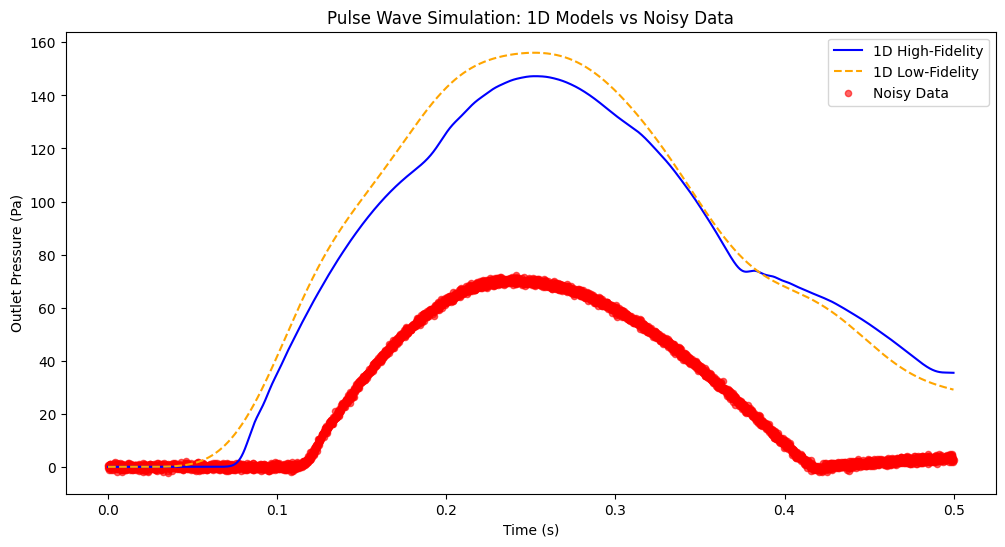

In [12]:
data = np.load('pulse_wave_data.npz')
t_eval = data['t_eval']
P_out = data['P_out']

# Initial guess for parameters (stiffness of daughter vessels)
E_1 = 1e5
E_2 = 1e5

P_out_hf, t_eval_fine = run_model_hf(E_1, E_2)
P_out_lf, t_eval_lf = run_model_lf(E_1, E_2)
plt.figure(figsize=(12, 6))
plt.plot(t_eval_fine, P_out_hf, label='1D High-Fidelity', color='blue')
plt.plot(t_eval_lf, P_out_lf, label='1D Low-Fidelity', color='orange', linestyle='--')
plt.scatter(t_eval, P_out, label='Noisy Data', color='red', s=20, alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Outlet Pressure (Pa)')
plt.title('Pulse Wave Simulation: 1D Models vs Noisy Data')
plt.legend()

## Instructions

1. Run the code cells to load the data and set up the problem.
2. Import the necessary `botorch` modules for multi-fidelity optimization.
3. Implement the multi-fidelity Bayesian optimization loop to calibrate the model parameters.
    1. Define an objective function that takes in the parameters `E_1` and `E_2` and returns the negative mean squared error (MSE) between the simulated pressure and the observed pressure at the outlet.
    2. Initialize a multi-fidelity Gaussian process model using the training data.
    3. In each iteration of the optimization loop:
        1. Use the model to find the next set of parameters to evaluate by maximizing the acquisition function (e.g., Expected Improvement).
        2. Evaluate the objective function at the new parameters (high fidelity evaluation).
        3. Update the training data with the new parameters and objective value.
        4. Update the model with the new training data.
4. After the optimization loop, report the best parameters found and the corresponding objective value.